## Explain an Intermediate Layer of VGG16 on ImageNet
Explaining a prediction in terms of the original input image is harder than explaining the predicition in terms of a higher convolutional layer (because the higher convolutional layer is closer to the output). This notebook gives a simple example of how to use GradientExplainer to do explain a model output with respect to the 7th layer of the pretrained VGG16 network.

Note that by default 200 samples are taken to compute the expectation. To run faster you can lower the number of samples per explanation.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import get_session
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

tf.compat.v1.disable_v2_behavior()
import shap
import tensorflow.keras.backend as K
from tensorflow import keras as tf_K
import json


# HACK: TODO: 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from tensorflow import keras
import yaml

#cfg = yaml.full_load(open("config.yml", 'r'))
#input_shape = cfg['DATA']['IMG_DIM'] + [3]
#thresholds = 1.0 / len(cfg['DATA']['CLASSES'])
#covid_class_idx = 0
#n_classes = 2
#output_bias = [0.0, 0.0]
#num_gpus = 1
#metrics = [CategoricalAccuracy(name='accuracy'), # TODO: Paul
#           Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
#           Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
#           AUC(name='auc'),
#           F1Score(name='f1score', thresholds=thresholds, class_id=covid_class_idx)]

#metrics = None
#model = dcnn_resnet(cfg['NN']['DCNN_BINARY'], input_shape, metrics, 2, output_bias=output_bias, gpus=num_gpus)
from tensorflow.keras.models import load_model
#custom_objects={'F1Score':F1Score()}
#model_temp = load_model(cfg['PATHS']['MODEL_WEIGHTS'] + 'model20201115-123712.h5', custom_objects=custom_objects, compile=False)
#model.load_weights('models/model.h5')
model = tf.keras.models.load_model('models/model20201115-145827-class_weight-NO-fiscore-resnet50v2.h5', compile=False)
model.load_weights('models/model20201115-145827-class_weight-NO-fiscore-resnet50v2.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
# HACK: TODO: 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
#import cv2
import os
import glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
data = []
X = np.empty([0,224,224,3])
#print(images_np)
#path = r'C:\g\RAW_DATA\Figure1-COVID-chestxray-dataset\images'

for file_name in glob.iglob('C:\g\RAW_DATA\Figure1-COVID-chestxray-dataset\images\*', recursive=True):
    #print(file_name)
    data.append(file_name)
    img = load_img(path=file_name, target_size = (224,224))
    input_arr = keras.preprocessing.image.img_to_array(img )
    batch_input_arr = input_arr.reshape(1,224,224,3)
    X = np.vstack((X, batch_input_arr))


Using TensorFlow backend.


In [5]:
X.shape

(55, 224, 224, 3)

In [6]:
# Need to load X-Ray Data

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array



img_width, img_height = 224, 224
                     
# Sample to test
image = "C:\g\RAW_DATA\Figure1-COVID-chestxray-dataset\images\COVID-00001.jpg"
image2 = "C:\g\RAW_DATA\Figure1-COVID-chestxray-dataset\images\COVID-00010.jpg"

#image = data[0]
img = load_img(path=image, target_size = (224, 224))
img2 = load_img(path=image, target_size = (224, 224))
input_arr = keras.preprocessing.image.img_to_array(img )
input_arr2 = keras.preprocessing.image.img_to_array(img2 )
batch_input_arr = input_arr.reshape(1,224,224,3)
batch_input_arr2 = input_arr2.reshape(1,224,224,3)
to_explain = np.vstack((batch_input_arr, batch_input_arr2))
#to_explain = batch_input_arr

In [7]:

to_explain.shape

(2, 224, 224, 3)

In [8]:
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return tf.compat.v1.keras.backend.get_session().run(model.layers[layer].input, feed_dict)

In [26]:
# from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions


layer_to_use = 7

e = shap.GradientExplainer((model.layers[layer_to_use].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), layer_to_use))

shap_values,indexes = e.shap_values(map2layer(to_explain, layer_to_use), ranked_outputs=2)

# get the names for the classes
#index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)


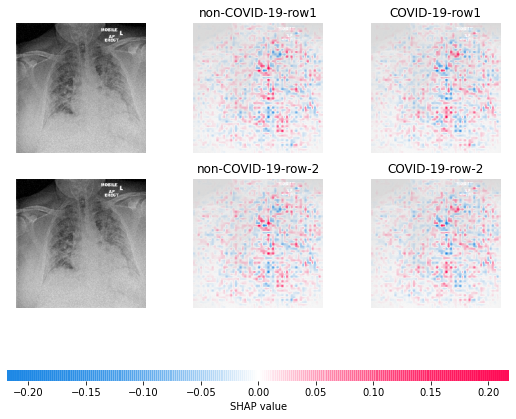

In [27]:
index_names = [['non-COVID-19-row1', 'COVID-19-row1'], ['non-COVID-19-row-2', 'COVID-19-row-2']]

shap.image_plot(shap_values, to_explain, index_names)

## Below is a WIP progress to loop layers

In [29]:

def try_layer(layer_to_use):
    e = shap.GradientExplainer((model.layers[layer_to_use].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), layer_to_use))
    shap_values,indexes = e.shap_values(map2layer(to_explain, layer_to_use), ranked_outputs=2)
    # get the names for the classes
    #index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
    index_names = [['non-COVID-19', 'COVID-19'], ['non-COVID-19', 'COVID-19']]  #TODO: make dynamic somehow from image array.
    shap.image_plot(shap_values, to_explain, index_names)
    

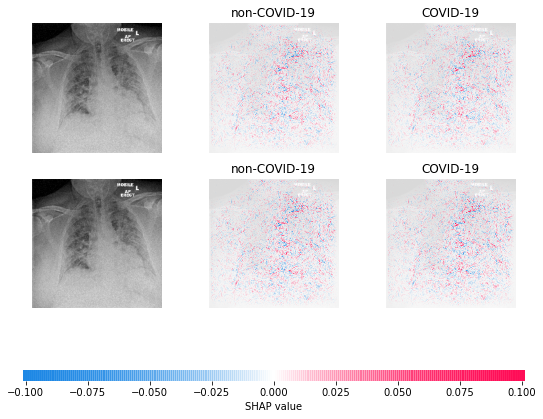

In [33]:
try_layer(2)